In [2]:
"""
compare_pima_dt_rf.py

Comparison of Decision Tree vs Random Forest on the Pima Indians Diabetes dataset.

Requirements:
    pip install numpy pandas scikit-learn matplotlib seaborn
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

In [3]:
# -------------------------
# 1) Load dataset (from UCI via URL)
# -------------------------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(url, names=columns)

print("\nDataset shape:", df.shape)
print("Class distribution:\n", df["Outcome"].value_counts())

X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values
feature_names = df.drop("Outcome", axis=1).columns


Dataset shape: (768, 9)
Class distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


In [4]:
# -------------------------
# 2) Train/test split + scaling
# -------------------------
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# -------------------------
# 3) Models
# -------------------------
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [6]:
# -------------------------
# 4) Small Grid Search for hyperparameters
# -------------------------
dt_param_grid = {
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10],
}
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [6, 10, None],
    "min_samples_split": [2, 5],
}

print("\nRunning GridSearch (small grid, quick)...")
dt_gs = GridSearchCV(dt, dt_param_grid, cv=5, scoring="f1", n_jobs=-1)
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5, scoring="f1", n_jobs=-1)

dt_gs.fit(X_train_scaled, y_train)
rf_gs.fit(X_train_scaled, y_train)

best_dt = dt_gs.best_estimator_
best_rf = rf_gs.best_estimator_

print("Best Decision Tree params:", dt_gs.best_params_)
print("Best Random Forest params:", rf_gs.best_params_)


Running GridSearch (small grid, quick)...
Best Decision Tree params: {'max_depth': 4, 'min_samples_split': 10}
Best Random Forest params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


In [7]:
# -------------------------
# 5) Evaluation function
# -------------------------
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    preds_tr = model.predict(X_tr)
    preds_te = model.predict(X_te)
    probs_te = model.predict_proba(X_te)[:, 1]

    metrics = {
        "train_acc": accuracy_score(y_tr, preds_tr),
        "test_acc": accuracy_score(y_te, preds_te),
        "precision": precision_score(y_te, preds_te),
        "recall": recall_score(y_te, preds_te),
        "f1": f1_score(y_te, preds_te),
        "roc_auc": roc_auc_score(y_te, probs_te),
        "confusion_matrix": confusion_matrix(y_te, preds_te),
        "report": classification_report(y_te, preds_te)
    }
    print(f"\n{name} classification report:\n{metrics['report']}")
    return metrics, probs_te

dt_metrics, dt_probs = evaluate_model("Decision Tree", best_dt, X_train_scaled, y_train, X_test_scaled, y_test)
rf_metrics, rf_probs = evaluate_model("Random Forest", best_rf, X_train_scaled, y_train, X_test_scaled, y_test)


Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       125
           1       0.66      0.69      0.67        67

    accuracy                           0.77       192
   macro avg       0.74      0.75      0.74       192
weighted avg       0.77      0.77      0.77       192


Random Forest classification report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       125
           1       0.68      0.54      0.60        67

    accuracy                           0.75       192
   macro avg       0.73      0.70      0.71       192
weighted avg       0.74      0.75      0.74       192



In [8]:
# -------------------------
# 6) Cross-validation
# -------------------------
cv = 5
dt_cv = cross_val_score(best_dt, X, y, cv=cv, scoring="f1", n_jobs=-1)
rf_cv = cross_val_score(best_rf, X, y, cv=cv, scoring="f1", n_jobs=-1)

print(f"\nDecision Tree CV F1: {dt_cv.mean():.4f} (+/- {dt_cv.std():.4f})")
print(f"Random Forest CV F1: {rf_cv.mean():.4f} (+/- {rf_cv.std():.4f})")


Decision Tree CV F1: 0.6408 (+/- 0.0368)
Random Forest CV F1: 0.6139 (+/- 0.0632)


In [9]:
# -------------------------
# 7) Results table
# -------------------------
results = pd.DataFrame([
    {"Model": "Decision Tree", **dt_metrics, "cv_f1_mean": dt_cv.mean()},
    {"Model": "Random Forest", **rf_metrics, "cv_f1_mean": rf_cv.mean()}
])
print("\nResults summary:")
print(results[["Model", "train_acc", "test_acc", "precision", "recall", "f1", "roc_auc", "cv_f1_mean"]].round(4))


Results summary:
           Model  train_acc  test_acc  precision  recall      f1  roc_auc  \
0  Decision Tree     0.8160    0.7656     0.6571  0.6866  0.6715   0.7772   
1  Random Forest     0.9774    0.7500     0.6792  0.5373  0.6000   0.8106   

   cv_f1_mean  
0      0.6408  
1      0.6139  


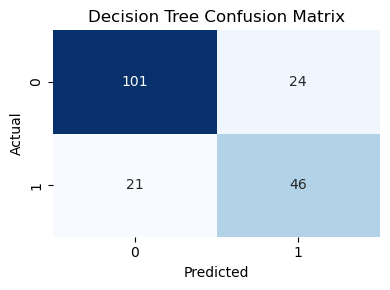

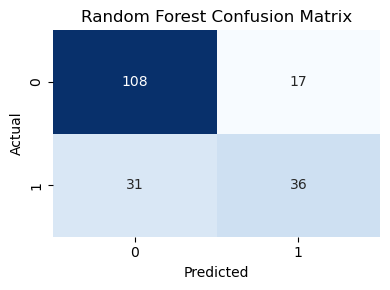

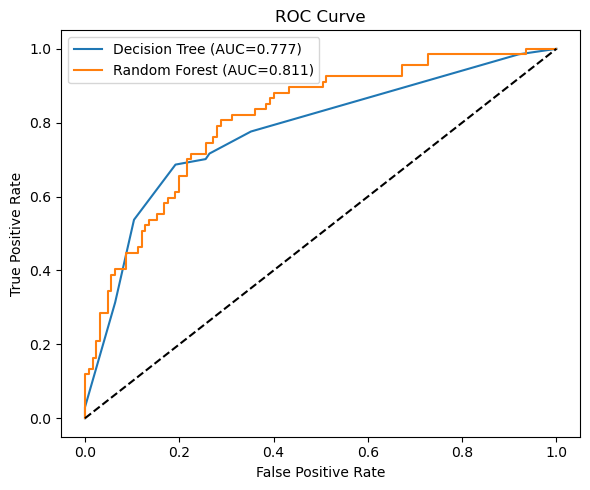

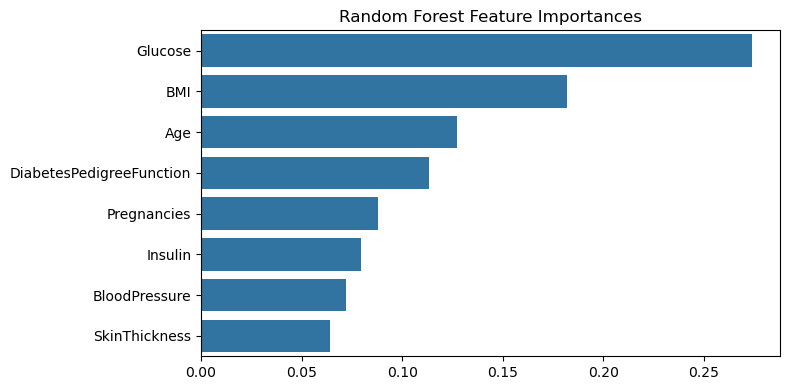

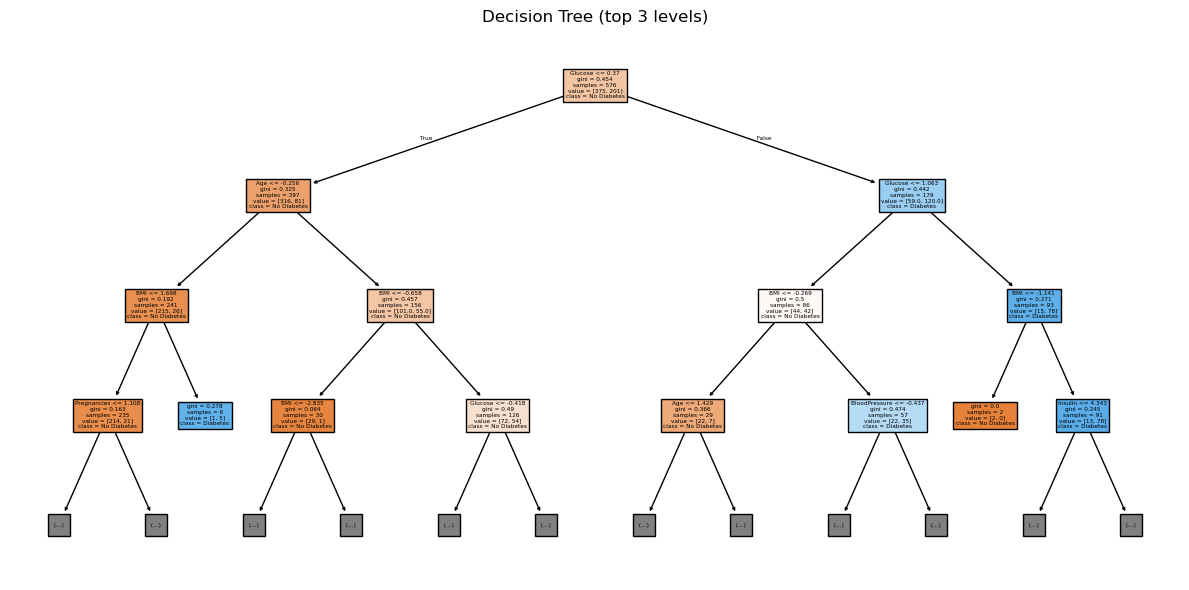

In [10]:
# -------------------------
# 8) Plots
# -------------------------
def plot_confusion(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

plot_confusion(dt_metrics["confusion_matrix"], "Decision Tree Confusion Matrix")
plot_confusion(rf_metrics["confusion_matrix"], "Random Forest Confusion Matrix")

# ROC curves
plt.figure(figsize=(6,5))
for name, probs in [("Decision Tree", dt_probs), ("Random Forest", rf_probs)]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()

# Feature importances (Random Forest)
plt.figure(figsize=(8,4))
importances = best_rf.feature_importances_
idx = np.argsort(importances)[::-1]
sns.barplot(x=importances[idx], y=np.array(feature_names)[idx])
plt.title("Random Forest Feature Importances")
plt.tight_layout()

# Decision Tree structure (top levels only)
plt.figure(figsize=(12,6))
plot_tree(best_dt, feature_names=feature_names, class_names=["No Diabetes","Diabetes"],
          filled=True, max_depth=3)
plt.title("Decision Tree (top 3 levels)")
plt.tight_layout()

plt.show()

In [11]:
# -------------------------
# 9) Summary
# -------------------------
print("\nSUMMARY:")
print("- Decision Tree: simpler, interpretable, but can overfit (watch training vs test acc).")
print("- Random Forest: ensemble averaging improves stability, often better F1 and ROC-AUC.")
print("- On Pima dataset, Random Forest usually outperforms Decision Tree in generalization.")


SUMMARY:
- Decision Tree: simpler, interpretable, but can overfit (watch training vs test acc).
- Random Forest: ensemble averaging improves stability, often better F1 and ROC-AUC.
- On Pima dataset, Random Forest usually outperforms Decision Tree in generalization.
